In [1]:
import requests
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(color_codes=True)

Step 1. Get the data from API and make a dataframe

In [2]:
# Make request to an URL
response = requests.get('http://localhost:8080/medish_centrum_randstad/api/netlify?page=1')

In [3]:
file_contents= response.json()  #dictionary
print(type(file_contents))
print(len(file_contents))

<class 'dict'>
6


In [4]:
life_df = pd.DataFrame.from_dict(file_contents['data']) #all the needed info was condensed into one data column called 'data'
display(life_df.head())
display(life_df.shape)

,genetic,length,mass,exercise,smoking,alcohol,sugar,lifespan
0,84.0,180.0,90.0,2.0,9.0,1.0,2,86
1,84.0,204.0,79.0,3.0,2.0,7.0,3,100
2,84.0,174.0,74.0,3.0,20.0,3.0,2,87
3,84.0,187.0,78.0,2.0,6.0,5.0,3,91
4,84.0,187.0,89.0,2.0,12.0,0.0,2,83


(8192, 8)

In [8]:
life_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8192 entries, 0 to 8191
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   genetic   8191 non-null   float64
 1   length    8190 non-null   float64
 2   mass      8191 non-null   float64
 3   exercise  8191 non-null   float64
 4   smoking   8191 non-null   float64
 5   alcohol   8191 non-null   float64
 6   sugar     8192 non-null   int64  
 7   lifespan  8192 non-null   int64  
dtypes: float64(6), int64(2)
memory usage: 512.1 KB


In [9]:
life_df.describe()

,genetic,length,mass,exercise,smoking,alcohol,sugar,lifespan
count,8191.000000,8190.000000,8191.000000,8191.000000,8191.000000,8191.000000,8192.000000,8192.000000
mean,79.967770,183.642735,79.794286,1.617141,9.773776,5.748260,2.423340,76.096069
std,1.634992,12.600441,12.076801,0.830975,6.967164,2.664489,0.950095,10.918167
min,76.000000,154.000000,60.000000,0.000000,0.000000,0.000000,1.000000,40.000000
25%,79.000000,174.000000,70.000000,1.000000,3.000000,4.000000,2.000000,68.000000
50%,80.000000,183.000000,79.000000,1.000000,10.000000,6.000000,2.000000,76.000000
75%,81.000000,193.000000,88.000000,2.000000,16.000000,8.000000,3.000000,83.000000
max,84.000000,214.000000,112.000000,4.000000,22.000000,10.000000,5.000000,113.000000


Step 2. Check the missing data and decide what to keep

In [10]:
analysis_df = life_df.copy()
analysis_df.isnull().sum()
#any missing values?

genetic     1
length      2
mass        1
exercise    1
smoking     1
alcohol     1
sugar       0
lifespan    0
dtype: int64

In [11]:
analysis_df = analysis_df.set_index('lifespan')
analysis_df = analysis_df.sort_index()
display(analysis_df.head())

,genetic,length,mass,exercise,smoking,alcohol,sugar
lifespan,,,,,,,
40,80.0,158.0,96.0,0.0,19.0,8.0,4
44,78.0,180.0,95.0,0.0,22.0,9.0,2
44,79.0,178.0,93.0,0.0,22.0,5.0,4
44,76.0,181.0,104.0,1.0,14.0,9.0,4
45,78.0,170.0,81.0,1.0,21.0,8.0,5


In [12]:
analysis_df.duplicated().sum()

3

In [13]:
#take look into missing values in mass
temp = (analysis_df
        .loc[(analysis_df['mass']
              .isnull())]
              .copy()
)
display(temp)

,genetic,length,mass,exercise,smoking,alcohol,sugar
lifespan,,,,,,,
89,78.0,176.0,NaN,3.0,3.0,3.0,4


In [14]:
temp1 = (analysis_df
        .loc[(analysis_df['length']
              .isnull())]
              .copy()
)
display(temp1)
#look at the missed value. I decide to drop this data because there are no substitute.

,genetic,length,mass,exercise,smoking,alcohol,sugar
lifespan,,,,,,,
74,80.0,NaN,90.0,2.0,7.0,7.0,3
82,79.0,NaN,75.0,2.0,0.0,6.0,3


Missing mass value is in lenth 176.0. Fill in the value using standized data.
(source: https://www.topendsports.com/testing/BMI-table.htm)

Delete other missing data's 

In [15]:
average_bmi_176 = (62.0+77.4)/2
analysis_df.loc[(analysis_df['mass'].isnull()),'mass']=average_bmi_176
tempdf = analysis_df.query('lifespan == 89')
#check if still null values
print(tempdf['mass'].isnull().sum())

0


Step 3. Define BMI and Exploratory Data Analysis 

In [17]:
analysis_df['BMI'] = analysis_df['mass']/(analysis_df['length']/100)**2
display(analysis_df.head())

,genetic,length,mass,exercise,smoking,alcohol,sugar,BMI
lifespan,,,,,,,,
40,80.0,158.0,96.0,0.0,19.0,8.0,4,38.455376
44,78.0,180.0,95.0,0.0,22.0,9.0,2,29.320988
44,79.0,178.0,93.0,0.0,22.0,5.0,4,29.352355
44,76.0,181.0,104.0,1.0,14.0,9.0,4,31.745063
45,78.0,170.0,81.0,1.0,21.0,8.0,5,28.027682


In [18]:
analysis_df['BMI'].value_counts().head(5)

19.576333    15
24.655910    15
23.629490    14
28.692653    14
22.014014    14
Name: BMI, dtype: int64

In [19]:
#Why is it missing? Is it random?
#Impute or delete?
analysis_df = analysis_df.dropna()
analysis_df.head()

,genetic,length,mass,exercise,smoking,alcohol,sugar,BMI
lifespan,,,,,,,,
40,80.0,158.0,96.0,0.0,19.0,8.0,4,38.455376
44,78.0,180.0,95.0,0.0,22.0,9.0,2,29.320988
44,79.0,178.0,93.0,0.0,22.0,5.0,4,29.352355
44,76.0,181.0,104.0,1.0,14.0,9.0,4,31.745063
45,78.0,170.0,81.0,1.0,21.0,8.0,5,28.027682


In [67]:
def bmi_category(bmi):
    if bmi > 40:
        return 'obese_3'
    elif bmi > 35:
        return 'obese_2'
    elif bmi > 30:
        return 'obese_1'
    elif bmi > 25:
        return 'over_weight'
    elif bmi >= 18.5:
        return 'normal_weight'
    elif bmi >= 17:
        return 'moderate_thin_weight'
    elif bmi >= 16:
        return 'mild_thin_weight'
    else:
        return 'severe_thin_weight'

In [68]:
import numpy as np
bmi_category = [0, 16, 17, 18.5, 25, 30, 35, 40, np.inf]
analysis_df['bmi_category']= pd.cut(analysis_df['BMI'], bins=bmi_category, labels=[ 'severe_thin_weight','mild_thin_weight','moderate_thin_weight','normal_weight','over_weight','obese_1','obese_2','obese_3'] )
analysis_df.head(12)

,genetic,length,mass,exercise,smoking,alcohol,sugar,BMI,bmi_category
lifespan,,,,,,,,,
40,80.0,158.0,96.0,0.0,19.0,8.0,4,38.455376,obese_2
44,78.0,180.0,95.0,0.0,22.0,9.0,2,29.320988,over_weight
44,79.0,178.0,93.0,0.0,22.0,5.0,4,29.352355,over_weight
44,76.0,181.0,104.0,1.0,14.0,9.0,4,31.745063,obese_1
45,78.0,170.0,81.0,1.0,21.0,8.0,5,28.027682,over_weight
45,80.0,174.0,80.0,1.0,22.0,10.0,4,26.423570,over_weight
46,79.0,158.0,89.0,1.0,22.0,9.0,3,35.651338,obese_2
46,80.0,163.0,83.0,0.0,16.0,9.0,3,31.239414,obese_1
46,77.0,164.0,93.0,1.0,12.0,8.0,4,34.577632,obese_1


<AxesSubplot: xlabel='BMI'>

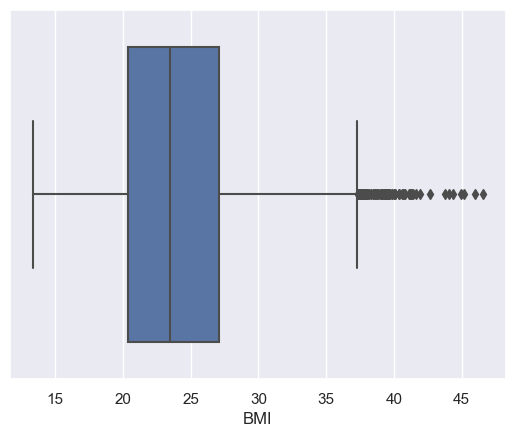

In [69]:
#got any outliers?
sns.boxplot(x=analysis_df['BMI'])

In [70]:
analysis_df[analysis_df['BMI'] > 35]
#Keep the outliers since obesity is an important factor.

,genetic,length,mass,exercise,smoking,alcohol,sugar,BMI,bmi_category
lifespan,,,,,,,,,
40,80.0,158.0,96.0,0.0,19.0,8.0,4,38.455376,obese_2
46,79.0,158.0,89.0,1.0,22.0,9.0,3,35.651338,obese_2
48,80.0,169.0,111.0,1.0,19.0,9.0,3,38.864185,obese_2
48,80.0,154.0,98.0,0.0,20.0,6.0,1,41.322314,obese_3
48,81.0,165.0,108.0,0.0,14.0,8.0,3,39.669421,obese_2
...,...,...,...,...,...,...,...,...,...
88,84.0,170.0,106.0,2.0,1.0,5.0,1,36.678201,obese_2
89,81.0,155.0,97.0,3.0,1.0,8.0,2,40.374610,obese_3
89,80.0,160.0,100.0,3.0,1.0,4.0,3,39.062500,obese_2


<AxesSubplot: xlabel='exercise'>

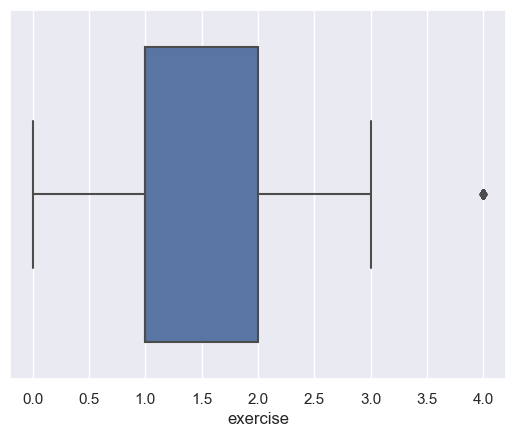

In [71]:
sns.boxplot(x=analysis_df['exercise'])

<AxesSubplot: xlabel='exercise', ylabel='BMI'>

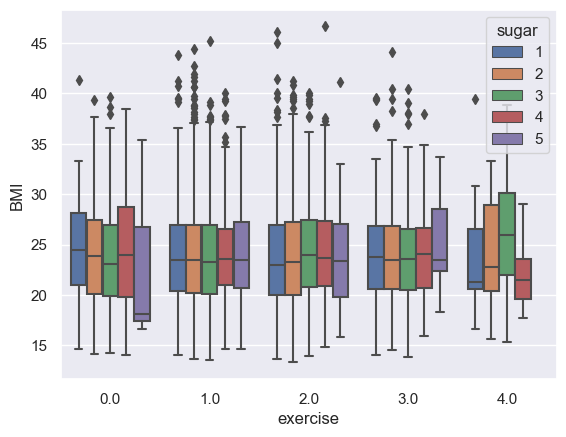

In [72]:
sns.boxplot(data=analysis_df, y="BMI", x='exercise', hue='sugar')

<AxesSubplot: xlabel='exercise', ylabel='BMI'>

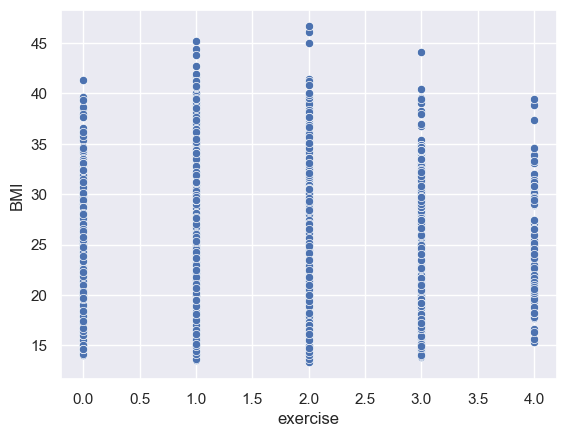

In [73]:
sns.scatterplot(data=analysis_df, y="BMI", x='exercise')

Text(0.5, 0, 'Exercise Index, exercise (kg/m^2)')

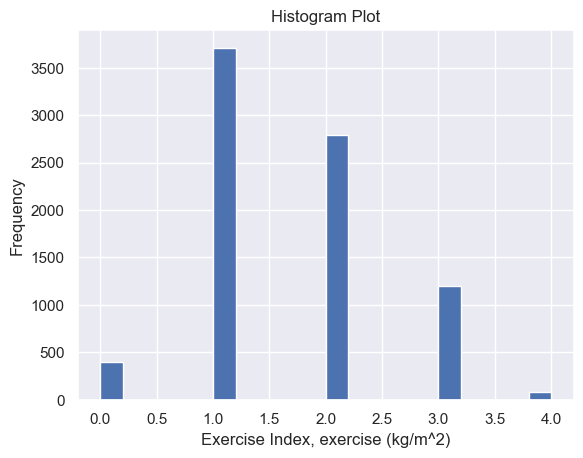

In [76]:
ax = analysis_df['exercise'].plot(kind='hist',bins=20,title='Histogram Plot')
ax.set_xlabel('Exercise Index, exercise (kg/m^2)')

Text(0.5, 0, 'Exercise Index, exercise (kg/m^2)')

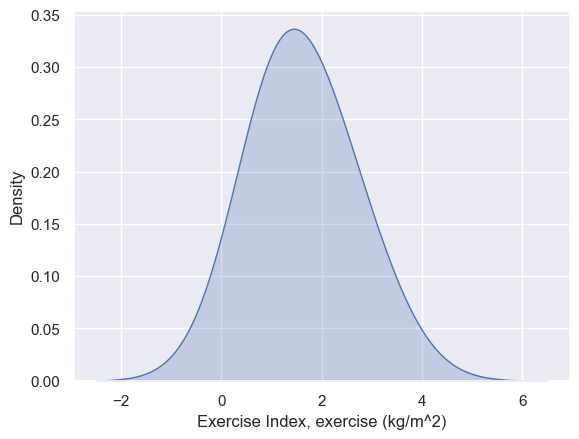

In [77]:
fig, ax = plt.subplots()

#ax1 = analysis_df['BMI'].plot(kind='kde', title='KDE Plot')

ax2 = sns.kdeplot(analysis_df['exercise'], fill=True, bw_method=1)
ax2.set_xlabel('Exercise Index, exercise (kg/m^2)')

In [25]:
temp = analysis_df.reset_index().copy()
display(temp)

,lifespan,genetic,length,mass,exercise,smoking,alcohol,sugar,BMI
0,40,80.0,158.0,96.0,0.0,19.0,8.0,4,38.455376
1,44,78.0,180.0,95.0,0.0,22.0,9.0,2,29.320988
2,44,79.0,178.0,93.0,0.0,22.0,5.0,4,29.352355
3,44,76.0,181.0,104.0,1.0,14.0,9.0,4,31.745063
4,45,78.0,170.0,81.0,1.0,21.0,8.0,5,28.027682
...,...,...,...,...,...,...,...,...,...
8181,110,80.0,200.0,83.0,4.0,0.0,5.0,1,20.750000
8182,110,80.0,198.0,64.0,4.0,3.0,4.0,2,16.324865
8183,111,80.0,196.0,66.0,3.0,0.0,2.0,2,17.180342
8184,112,79.0,192.0,76.0,4.0,0.0,2.0,1,20.616319


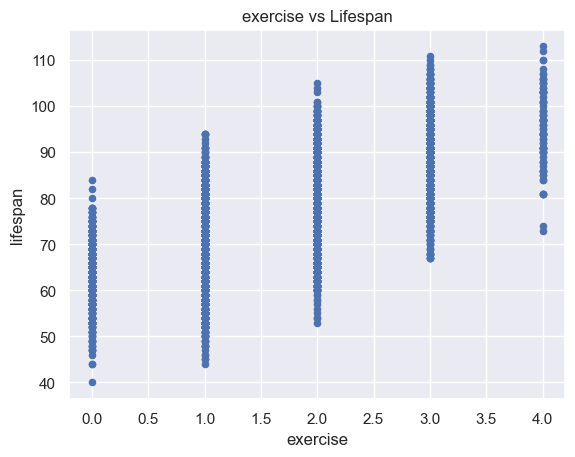

In [78]:
ax = temp.plot(kind='scatter', y='lifespan', x='exercise', title='exercise vs Lifespan')

<AxesSubplot: xlabel='exercise', ylabel='lifespan'>

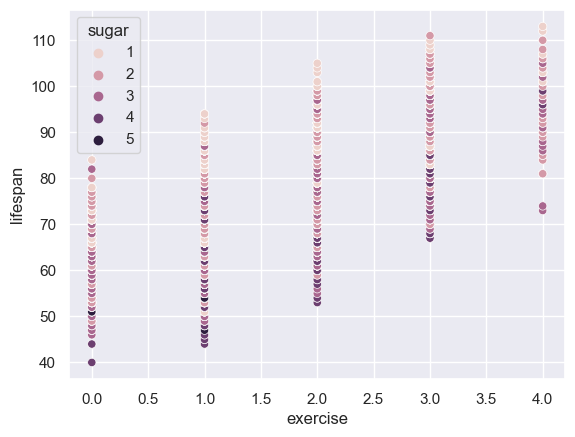

In [79]:
sns.scatterplot(data=temp, x='exercise',y='lifespan', hue='sugar') 

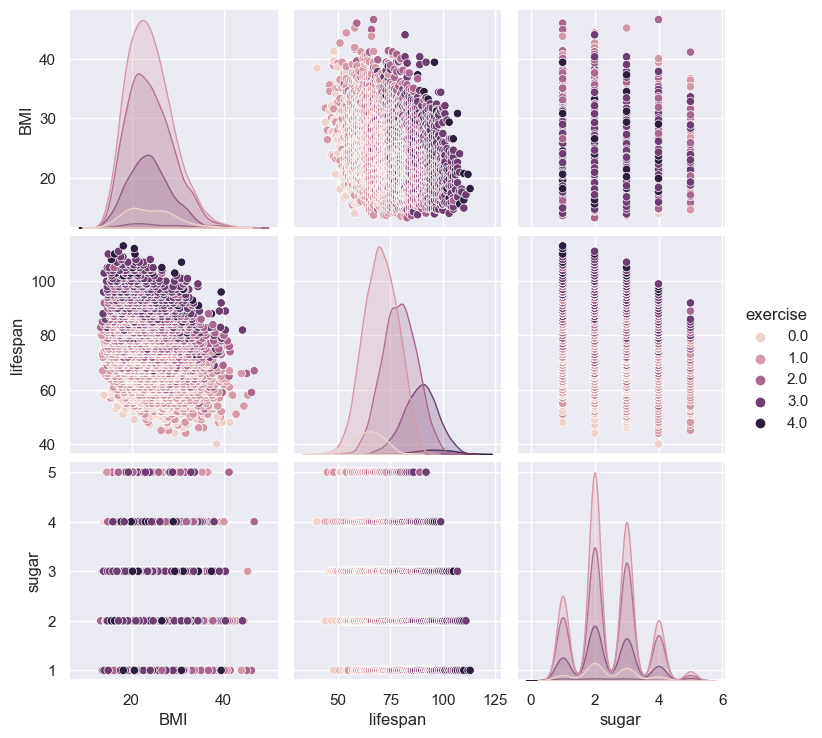

In [80]:
sns.pairplot(data=temp,vars=['BMI','lifespan','sugar'], hue='exercise')

In [84]:
df_corr = temp[['genetic',
      'length', 'mass', 
      'exercise', 'smoking',
       'alcohol', 'sugar', 'BMI','lifespan']].dropna().corr()
df_corr.style.background_gradient(cmap='RdBu')

,genetic,length,mass,exercise,smoking,alcohol,sugar,BMI,lifespan
genetic,1.000000,-0.002061,-0.009935,0.004218,-0.010887,0.003763,-0.006869,-0.008239,0.151944
length,-0.002061,1.000000,0.017811,-0.007374,-0.008893,0.006826,-0.015382,-0.661735,0.179804
mass,-0.009935,0.017811,1.000000,0.004133,0.016246,-0.002077,0.006609,0.726119,-0.201582
exercise,0.004218,-0.007374,0.004133,1.000000,-0.012952,0.005744,-0.008909,0.005216,0.677432
smoking,-0.010887,-0.008893,0.016246,-0.012952,1.000000,0.001535,-0.001565,0.019533,-0.525678
alcohol,0.003763,0.006826,-0.002077,0.005744,0.001535,1.000000,0.013651,-0.006216,-0.216934
sugar,-0.006869,-0.015382,0.006609,-0.008909,-0.001565,0.013651,1.000000,0.014166,-0.263588
BMI,-0.008239,-0.661735,0.726119,0.005216,0.019533,-0.006216,0.014166,1.000000,-0.276982
lifespan,0.151944,0.179804,-0.201582,0.677432,-0.525678,-0.216934,-0.263588,-0.276982,1.000000


lifespan is highly related to exercise.

<AxesSubplot: >

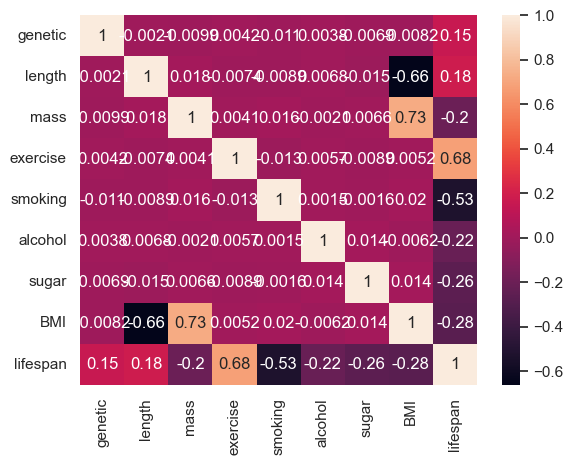

In [86]:
sns.heatmap(df_corr,annot=True)

In [87]:
analysis_df.groupby('bmi_category')['sugar', 'exercise'].mean()

C:\Users\jiyoo\AppData\Local\Temp\ipykernel_12412\3594314296.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  analysis_df.groupby('bmi_category')['sugar', 'exercise'].mean()


,sugar,exercise
bmi_category,,
severe_thin_weight,2.307292,1.609375
mild_thin_weight,2.420354,1.539823
moderate_thin_weight,2.378862,1.603252
normal_weight,2.424416,1.631278
over_weight,2.443519,1.599074
obese_1,2.422980,1.654040
obese_2,2.474026,1.500000
obese_3,2.080000,1.560000
